In [2]:
import pandas as pd
import seaborn as sns
from pylab import rcParams
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

In [4]:
def connect(user, password, db, host: str, port: int, echo=True):
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)
    eng = sqlalchemy.create_engine(url, client_encoding='utf8', echo=echo)
    meta = sqlalchemy.MetaData(bind=eng)

    return eng, meta


def get_data_frame(pair: str = 'USDT_BTC', exchange: str = 'poloniex') -> pd.DataFrame:
    """Метод стягивания данных из базы в датафрейм.
    По умолчанию тянет все значения в базе для валютной пары доллар биткоин.
    Список спаршенных пар смотри в таблице Pair
    Цепляться будет отовсюду где есть инетрнет"""
    engine, meta = connect(user='postgres', password='password', db='btccandles', host='94.230.125.199', port=16432)
    df = pd.read_sql_query(
        "SELECT date, time, open, close, low, high, volume, pair.\"name\""
        "FROM candlestick, pair WHERE candlestick.pair_id = pair.id AND pair.id IN ("
        "SELECT pair.id FROM pair, exchange WHERE ("
        "SELECT pair.id FROM pair WHERE pair.name = '" + pair +
        "') = pair.alias_id AND pair.exchange_id = (SELECT exchange.id FROM exchange WHERE exchange.\"name\" = '" + exchange + "'));",
        con=engine)
    return df

df = get_data_frame("USDT_BTC")

2017-07-25 12:16:17,075 INFO sqlalchemy.engine.base.Engine select version()
2017-07-25 12:16:17,076 INFO sqlalchemy.engine.base.Engine {}
2017-07-25 12:16:17,078 INFO sqlalchemy.engine.base.Engine select current_schema()
2017-07-25 12:16:17,079 INFO sqlalchemy.engine.base.Engine {}
2017-07-25 12:16:17,080 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2017-07-25 12:16:17,081 INFO sqlalchemy.engine.base.Engine {}
2017-07-25 12:16:17,082 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2017-07-25 12:16:17,083 INFO sqlalchemy.engine.base.Engine {}
2017-07-25 12:16:17,085 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2017-07-25 12:16:17,086 INFO sqlalchemy.engine.base.Engine {}
2017-07-25 12:16:17,087 INFO sqlalchemy.engine.base.Engine SELECT date, time, open, close, low, high, volume, pair."name"FROM candlestick, pair WHERE candlestick.pair_id = pair.id AND pair.id IN (SELEC

In [5]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

openValue = go.Scatter( x = df.date, y = df.open, name = 'openValue')
closeValues = go.Scatter( x = df.date, y = df.close, name = 'closeValues')
highValue = go.Scatter( x = df.date, y = df.high, name = 'highValue')

iplot([openValue, highValue])

In [6]:
import plotly.graph_objs as go

trace = go.Candlestick(x=df.date,
                       open=df.open,
                       high=df.high,
                       low=df.low,
                       close=df.close,
                      text = df.columns)
layout = {
    'title': 'Candlestick BTC data',
    'yaxis': {'title': 'BTC-USD'},    
}
candleData = [trace]

fig = dict(data=candleData, layout=layout)

iplot(fig)

# Тест Дикки-Фуллера

Проверка стационарности временного ряда https://wikipedia.org/wiki/Тест_Дики_—_Фуллера

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



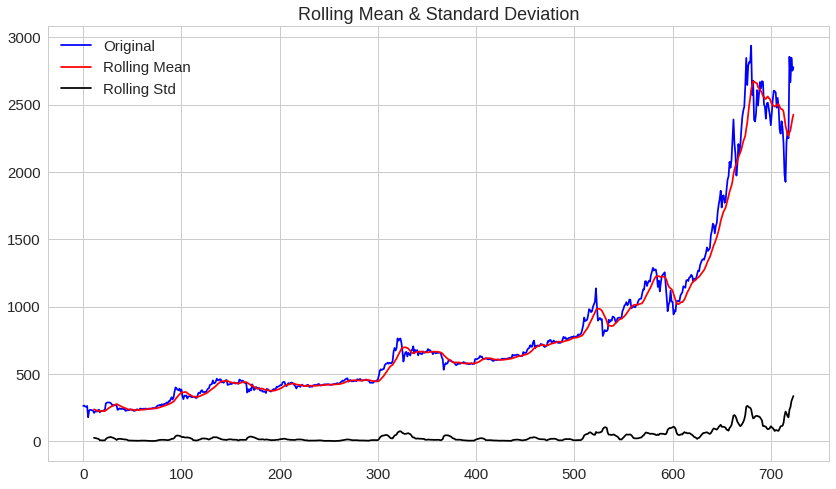

In [11]:
from statsmodels.tsa.stattools import adfuller

timeseries = df.close

rolmean = pd.rolling_mean(timeseries, window=12)
rolstd = pd.rolling_std(timeseries, window=12)

orig = plt.plot(timeseries, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [12]:
print ('Results of Dickey-Fuller Test:')

dftest = adfuller(timeseries, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   1.210526
p-value                          0.996058
#Lags Used                      18.000000
Number of Observations Used    705.000000
Critical Value (1%)             -3.439660
Critical Value (5%)             -2.865648
Critical Value (10%)            -2.568958
dtype: float64


/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()



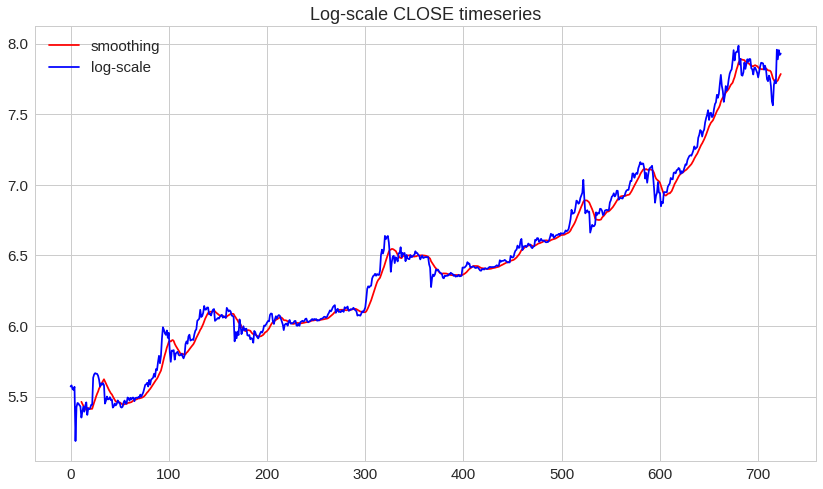

In [13]:
log_scale = np.log(timeseries)
moving_avg = pd.rolling_mean(log_scale, 12)

plt.title('Log-scale CLOSE timeseries')
plt.plot(moving_avg, label = 'smoothing',color='red')
plt.plot(log_scale, label = 'log-scale', color = 'blue')
plt.legend()
plt.show()

# Trend and seson

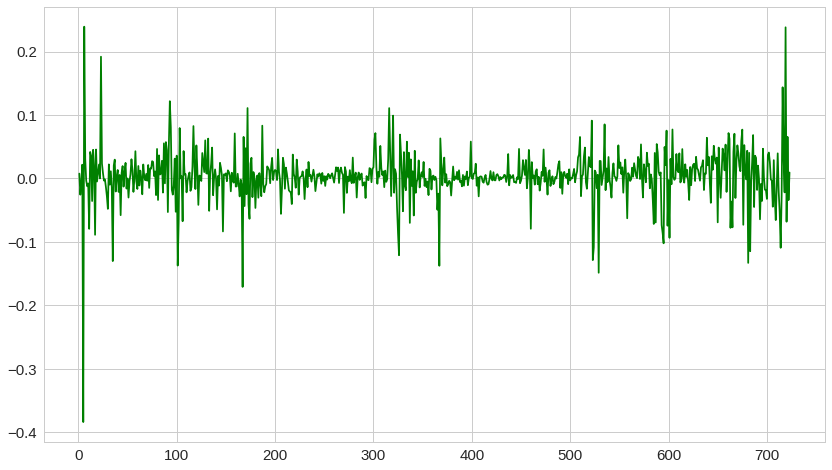

In [14]:
ts_log_diff = log_scale - log_scale.shift()
plt.plot(ts_log_diff, color = 'green')
plt.show()

## Statmodels tools for time-series analisys

http://www.statsmodels.org/dev/tsa.html

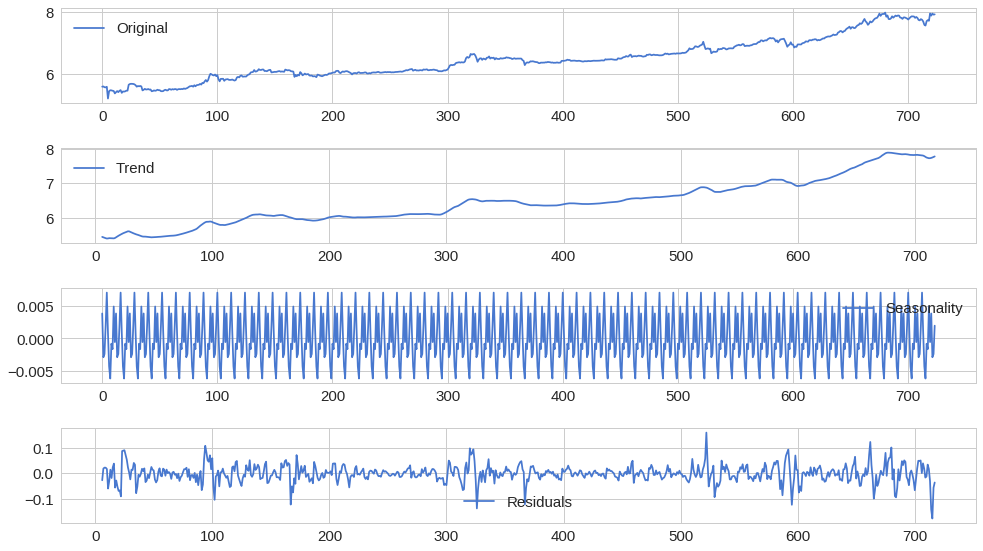

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(log_scale.values, freq=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(log_scale.values, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()